Imports


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import random

Creating Value object and it's properties

In [ ]:
class Value:
  def __init__(self , data , _children = () , _op='' , label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda:None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self , other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data , (self , other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self , other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self , other):
    return self * other

  def __truediv__(self , other):
    return self * other ** -1

  def __sub__(self , other):
    return self + (-other)

  def __neg__(self ):
    return self * (-1)

  def __radd__(self , other):
    return self + other


  def __pow__(self , other):
    assert isinstance(other , (int , float)) , "only supporting int/float for now!"
    out = Value(self.data ** other , (self , ) , f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = ((math.exp(2*x) - 1) / (math.exp(2*x) + 1))
    out = Value( t , (self , ) , 'tanh')
    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data , (self , ) , 'ReLU')
    def backward():
      self.grad += (0 if self.data < 0 else 1.0 ) * out.grad
    out._backward = _backward
    return out

  def sigmoid(self):
    x = self.data
    out = Value(1 / (1 + math.exp(-x)) , (self , ) , 'ReLU')
    def _backward():
      self.grad += (out.data * (1 - out.data)) * out.grad
    out._backward. = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x) , (self , ) , 'exp')

    def _backward():
      self.grad += out.grad * out.data

    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1

    for node in reversed(topo):
      node._backward()



Visualizing tool

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')
w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')
b = Value(6.7 , label = 'b')
x1w1 = x1 * w1 ; x1w1.label = 'x1w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'

e = (n * 2 ).exp() ; e.label = 'e'
o = (e - 1) / (e + 1) ; o.label = 'o'

In [ ]:
b + 1

Value(data = 7.7)

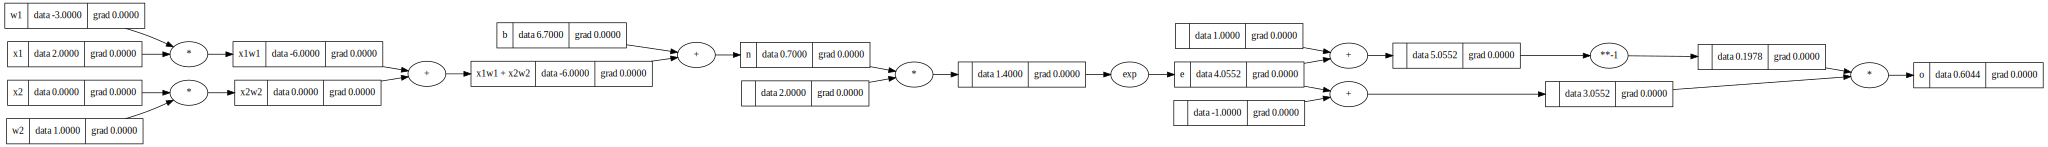

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
x1 = torch.Tensor([2.0]).double()               ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ;w2.requires_grad = True

b = torch.Tensor([6.88137358701]).double()      ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

print('____')
o.backward()
print('x1' , x1.grad.item())
print('w1' , w1.grad.item())
print('x2' , x2.grad.item())
print('w2' , w2.grad.item())



0.7071066904050358
____
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [ ]:
#creating MLP step by step

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
#custom made dataset

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.5901788114912467)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
#epoch/training manual code

In [ ]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 5.16849629172083
1 2.8050478162999597
2 2.52121859032995
3 2.2467556603456855
4 1.920077001098706
5 1.5136169877660568
6 1.0661336065999922
7 0.6922894469587416
8 0.45584079793333565
9 0.32117653153699394
10 0.2414467940767575
11 0.19069123758099674
12 0.15620447752219782
13 0.1315157958878047
14 0.11309812141689919
15 0.09890019882555719
16 0.08766065887060191
17 0.0785666179217817
18 0.07107316185380093
19 0.06480262633114288
